In [1]:
import matplotlib.pyplot as plt
from dzdy import *

In [2]:
par_script = """ 
PCore pSIR{
    transmission_rate = 0.015
    rec_rate ~ triangle(0.1, 0.2, 0.3)
    beta ~ exp(transmission_rate)
    gamma ~ exp(rec_rate)
    Die ~ exp(0.02)
}
"""

dc_ctbn_script = '''
CTBN SIR_BN {
    life[Alive | Dead]
    sir[S | I | R]
    
    Alive{life:Alive}
    Dead{life:Dead}
    Inf{life:Alive, sir:I}
    Rec{life:Alive, sir:R}
    Sus{life:Alive, sir:S}

    Die -> Dead # from transition Die to state Dead by distribution Die
    Sus -- Infect(beta) -> Inf 
    Inf -- Recov(gamma) -> Rec
    
    Alive -- Die # from state Alive to transition Die
}
'''

da = Director()
da.read_pc(par_script)
da.read_dc(dc_ctbn_script)

In [3]:
cfd = da.new_mc('ABM_M2', 'ABM', tar_pc='pSIR', tar_dc='SIR_BN')
cfd.add_network('IDU', 'BA', m=2)
cfd.add_behaviour('cycle', be_type='Reincarnation', s_birth = 'Sus', s_death = 'Dead')
cfd.add_behaviour('transmission', be_type='NetShock', s_src = 'Inf', t_tar = 'Infect', net='IDU')

cfd.set_observations(states=['Sus', 'Inf', 'Rec'])

cfd = da.new_mc('ABM_M5', 'ABM', tar_pc='pSIR', tar_dc='SIR_BN')
cfd.add_network('IDU', 'BA', m=5)
cfd.add_behaviour('cycle', be_type='Reincarnation', s_birth = 'Sus', s_death = 'Dead')
cfd.add_behaviour('transmission', be_type='NetShock', s_src = 'Inf', t_tar = 'Infect', net='*')

cfd.set_observations(states=['Sus', 'Inf', 'Rec'])

In [4]:
lyo = da.new_layout('Lyo1')
lyo.add_entry('A', 'ABM_M2', {'Sus': 20, 'Inf': 10})
lyo.add_entry('B', 'ABM_M2', {'Sus': 20}, size=3)
lyo.add_entry('C', 'ABM_M5', {'Sus': 20, 'Inf': 10}, size=2)

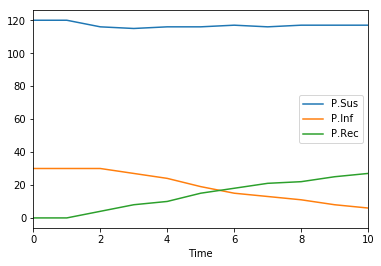

In [5]:
mod, out = da.simulate('Lyo1', fr=0, to=10)
out.plot()
plt.show()

In [6]:
mod.Models['A'].Pop.Networks['IDU']

Barabasi_Albert(N=30, M=2)

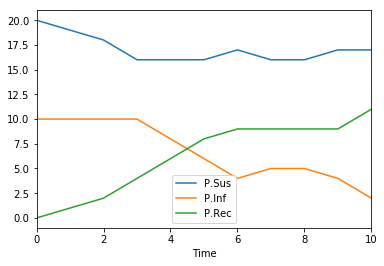

In [7]:
mod, out = da.simulate('ABM_M2', y0={'Sus': 20, 'Inf': 10},fr=0, to=10)
out.plot()
plt.show()

In [8]:
mod.Pop.Eve.States

{'Inf': Inf,
 'Rec': Rec,
 'Sus': Sus,
 '[life=Dead, sir=I]': [life=Dead, sir=I],
 '[life=Dead, sir=R]': [life=Dead, sir=R],
 '[life=Dead, sir=S]': [life=Dead, sir=S]}

In [ ]:
import numpy as np


In [22]:
class LinearCombination:
    def __init__(self, intercept=0, default=0, ):
        self.Coefficients = dict()
        self.TransFunc = None
        self.Intercept = intercept
        self.Default = default
        
    def __setitem__(self, cov, coef):
        self.Coefficients[cov] = coef
        
    def add_covariate(self, cov, coef=1):
        self.Coefficients[cov] = coef
        
    def add_covariates(self, covs):
        self.Coefficients.update(covs)
        
    def calculate(self, covs):
        y = sum([coef*(covs[cov] if cov in covs else self.Default) for cov, coef in self.Coefficients.items()])
        y += self.Intercept
        try:
            return self.TransFunc(y)
        except TypeError:
            return y
        
    def __repr__(self):
        func = ['{}{}{}'.format('+'if v>=0 else '',v, k) for k, v in self.Coefficients.items()]
        func.append('{}{}'.format('+'if self.Intercept>=0 else '', self.Intercept))
        func = ' '.join(func)
        
        return func
        

In [23]:
reg = LinearCombination(-20)
reg.add_covariates({'X1': 1, 'X2': -2})
reg

+1X1 -2X2 -20

In [25]:
reg.calculate({'X1': 10})

-10